In [1]:
import pandas as pd       #data processing
import numpy as np        #linear algebra

#data visualisation
import seaborn as sns     
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt
import warnings; warnings.simplefilter('ignore')

from IPython.display import clear_output

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
%cd /content/drive/My\ Drive/algorithms
os.listdir()

/content/drive/My Drive/algorithms


['a1-centroid 2',
 'yellow_tripdata_2015-01.csv',
 'NYC_yellow_cab_trip_2016.csv',
 '(draft)KMeans++.ipynb',
 'manhattan.png',
 'kmeans++_localSearch.ipynb',
 'NYC_taxi.ipynb']

In [4]:
# data = pd.read_csv("NYC_yellow_cab_trip_2016.csv")
data=pd.read_csv("yellow_tripdata_2015-01.csv")

In [5]:
# data.shape

In [6]:
# data.columns

In [7]:
# data.dtypes

In [8]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [9]:
# data.isnull().sum()

In [10]:
# data.nunique()

In [11]:
data.describe()

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07,1.274898e+07,1.274899e+07
mean,1.521437e+00,1.681491e+00,1.345913e+01,-7.256184e+01,3.997282e+01,1.036901e+00,-7.260904e+01,3.999961e+01,1.386712e+00,1.190566e+01,3.082790e-01,4.977986e-01,1.853814e+00,2.434984e-01,2.831431e-01,1.510829e+01
std,4.995402e-01,1.337924e+00,9.844094e+03,1.012510e+01,5.578691e+00,6.732240e-01,9.966037e+00,5.487742e+00,4.988611e-01,1.030254e+01,5.916643e-01,3.534229e-02,1.106432e+03,1.527171e+00,6.908633e-02,1.106503e+03
min,1.000000e+00,0.000000e+00,0.000000e+00,-1.219258e+02,0.000000e+00,1.000000e+00,-7.401667e+02,-9.029157e+00,1.000000e+00,-4.500000e+02,-7.900000e+01,-5.000000e-01,-9.242000e+01,-2.600000e+01,0.000000e+00,-4.503000e+02
25%,1.000000e+00,1.000000e+00,1.000000e+00,-7.399168e+01,4.073554e+01,1.000000e+00,-7.399120e+01,4.073436e+01,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.160000e+00
50%,2.000000e+00,1.000000e+00,1.680000e+00,-7.398160e+01,4.075314e+01,1.000000e+00,-7.397976e+01,4.075362e+01,1.000000e+00,9.000000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,3.000000e-01,1.116000e+01
75%,2.000000e+00,2.000000e+00,3.000000e+00,-7.396662e+01,4.076757e+01,1.000000e+00,-7.396246e+01,4.076880e+01,2.000000e+00,1.350000e+01,5.000000e-01,5.000000e-01,2.060000e+00,0.000000e+00,3.000000e-01,1.630000e+01
max,2.000000e+00,9.000000e+00,1.542000e+07,7.866265e+01,4.047000e+02,9.900000e+01,8.527402e+01,4.595333e+02,5.000000e+00,4.008000e+03,9.999900e+02,5.000000e-01,3.950589e+06,1.450090e+03,3.000000e-01,3.950612e+06


In [12]:
data['tpep_pickup_datetime']=pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime']=pd.to_datetime(data['tpep_dropoff_datetime'])

data['pickup_month']=data['tpep_pickup_datetime'].dt.month
data['dropoff_month']=data['tpep_dropoff_datetime'].dt.month

data['pickup_day']=data['tpep_pickup_datetime'].dt.day
data['dropoff_day']=data['tpep_dropoff_datetime'].dt.day

data['pickup_hour']=data['tpep_pickup_datetime'].dt.hour
data['dropoff_hour']=data['tpep_dropoff_datetime'].dt.hour

data['pickup_minute']=data['tpep_pickup_datetime'].dt.minute
data['dropoff_minute']=data['tpep_dropoff_datetime'].dt.minute

In [13]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_month,dropoff_month,pickup_day,dropoff_day,pickup_hour,dropoff_hour,pickup_minute,dropoff_minute
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05,1,1,15,15,19,19,5,23
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80,1,1,10,10,20,20,33,53
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80,1,1,10,10,20,20,33,43
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,1,1,10,10,20,20,33,35
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30,1,1,10,10,20,20,33,52


In [14]:
del data['store_and_fwd_flag']
del data['RateCodeID']
del data['payment_type']
del data['fare_amount']
del data['extra']
del data['mta_tax']
del data['tip_amount']
del data['tolls_amount']
del data['improvement_surcharge']
del data['total_amount']

In [15]:
import math

radius = 6371    #Earth Radius in KM

class referencePoint:
    def __init__(self, scrX, scrY, lat, lng):
        self.scrX = scrX
        self.scrY = scrY
        self.lat = lat
        self.lng = lng


# Calculate global X and Y for top-left reference point        
p0 = referencePoint(0, 0, 40.88104503491091, -74.02323943194315)
# Calculate global X and Y for bottom-right reference point
p1 = referencePoint(471, 907, 40.701400864163276, -73.90045275291787) 


# This function converts lat and lng coordinates to GLOBAL X and Y positions
def latlngToGlobalXY(lat, lng):
    # Calculates x based on cos of average of the latitudes
    x = radius*lng*math.cos((p0.lat + p1.lat)/2)
    # x = radius * lng
    # Calculates y based on latitude
    y = radius*lat
    return {'x': x, 'y': y}

p0_pos = latlngToGlobalXY(p0.lat, p0.lng)
p1_pos = latlngToGlobalXY(p1.lat, p1.lng)


# This function converts lat and lng coordinates to SCREEN X and Y positions
def latlngToScreenXY(lat, lng):
    # Calculate global X and Y for projection point
    pos = latlngToGlobalXY(lat, lng)
    # Calculate the percentage of Global X position in relation to total global width
    perX = ((pos['x']-p0_pos['x'])/(p1_pos['x'] - p0_pos['x']))
    # Calculate the percentage of Global Y position in relation to total global height
    perY = ((pos['y']-p0_pos['y'])/(p1_pos['y'] - p0_pos['y']))

    # Returns the screen position based on reference points
    return {
        'x': p0.scrX + (p1.scrX - p0.scrX)*perX,
        'y': p0.scrY + (p1.scrY - p0.scrY)*perY
    }


# pos = latlngToScreenXY(40.767937, -73.982155)
# print(pos)

In [19]:
data_may23 = data[(data['pickup_month']==1) & (data['pickup_day']==23)]

data_may23['pickup_coords']=data_may23.apply(lambda x: latlngToScreenXY(x['pickup_latitude'], x['pickup_longitude']), axis=1)
data_may23['dropoff_coords']=data_may23.apply(lambda x: latlngToScreenXY(x['dropoff_latitude'], x['dropoff_longitude']), axis=1)

data_may23['pickup_x'] = data_may23['pickup_coords'].apply(lambda x: x['x'])
data_may23['pickup_y'] = data_may23['pickup_coords'].apply(lambda x: x['y'])
data_may23['dropoff_x'] = data_may23['dropoff_coords'].apply(lambda x: x['x'])
data_may23['dropoff_y'] = data_may23['dropoff_coords'].apply(lambda x: x['y'])

# data that fit in the image
data_may23 = data_may23[(data_may23['pickup_x'] >= 0) & (data_may23['pickup_x'] <= 471) & (data_may23['pickup_y'] <= 907) & (data_may23['pickup_y'] >= 0)]

In [20]:
data_may23.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_month,dropoff_month,pickup_day,dropoff_day,pickup_hour,dropoff_hour,pickup_minute,dropoff_minute,pickup_coords,dropoff_coords,pickup_x,pickup_y,dropoff_x,dropoff_y
450,1,2015-01-23 16:51:34,2015-01-23 17:19:19,4,6.8,-74.013306,40.714504,-73.983253,40.754368,1,1,23,23,16,17,51,19,"{'x': 38.105148774530406, 'y': 840.8427537221294}","{'x': 153.38295639145448, 'y': 639.576702406901}",38.105149,840.842754,153.382956,639.576702
451,1,2015-01-23 16:51:35,2015-01-23 16:53:44,1,0.4,-73.983833,40.733826,-73.988197,40.728039,1,1,23,23,16,16,51,53,"{'x': 151.1587590369933, 'y': 743.2913135391757}","{'x': 134.41874736999154, 'y': 772.5085958210199}",151.158759,743.291314,134.418747,772.508596
452,1,2015-01-23 16:51:35,2015-01-23 16:55:32,1,1.1,-73.966026,40.762295,-73.955742,40.776218,1,1,23,23,16,16,51,55,"{'x': 219.4650304201576, 'y': 599.5546110544012}","{'x': 258.9152677056594, 'y': 529.2559424131808}",219.465030,599.554611,258.915268,529.255942
453,1,2015-01-23 16:51:35,2015-01-23 17:00:11,1,0.8,-73.984100,40.756226,-73.991188,40.750500,1,1,23,23,16,17,51,0,"{'x': 150.1344576239633, 'y': 630.1971266182865}","{'x': 122.94657154211153, 'y': 659.1062503526623}",150.134458,630.197127,122.946572,659.106250
454,1,2015-01-23 16:51:36,2015-01-23 17:05:19,1,1.8,-73.993820,40.751266,-73.971336,40.761940,1,1,23,23,16,17,51,5,"{'x': 112.84988618343223, 'y': 655.235008600091}","{'x': 199.09606517481893, 'y': 601.345782611561}",112.849886,655.235009,199.096065,601.345783


In [18]:
import matplotlib.pyplot as plt

def plot(x, y):
    im = plt.imread('manhattan.png')
    dpi = 80
    height, width, depth = im.shape
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im, cmap='gray')
    implot = plt.imshow(im)

    # put dots at (x,y)
    plt.scatter(x, y, c='r', s=3)

    plt.show()

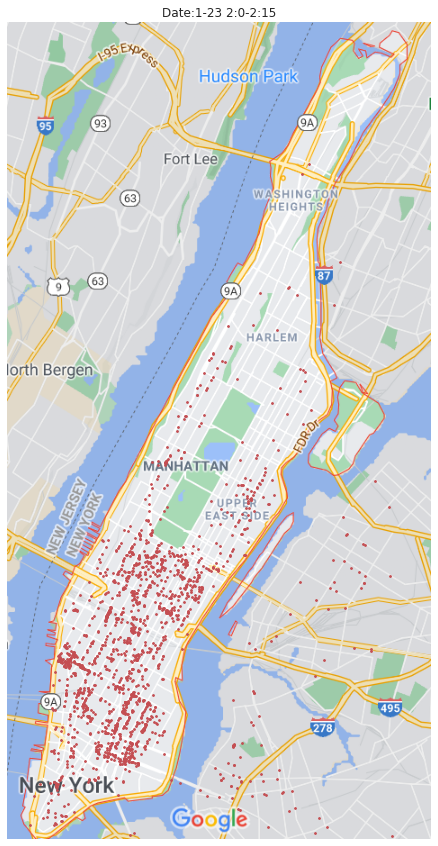

KeyboardInterrupt: ignored

In [24]:

month, day = 1, 23

# pick a day
# data_may23 = data[(data['pickup_month']==5) & (data['pickup_day']==23)]
# data_tmp = data[data['pickup_month']<5]

# plot
# plot(data_may23['pickup_x'], data_may23['pickup_y'])

### every five minutes in this day
min = 0
interval = 15

for h in range(0, max(data_may23['pickup_hour'])):
    while min<=59 :
        tmp_data_may23 = data_may23[(data_may23['pickup_hour']==h) & (data_may23['pickup_minute']<min+interval) & (data_may23['pickup_minute']>=min)]
        x = tmp_data_may23['pickup_x']
        y = tmp_data_may23['pickup_y']
        
        im = plt.imread('manhattan.png')
        dpi = 80
        height, width, depth = im.shape
        figsize = width / float(dpi), height / float(dpi)
        fig = plt.figure(figsize=figsize)
        ax = fig.add_axes([0, 0, 1, 1])

        # Hide spines, ticks, etc.
        ax.axis('off')

        # Display the image.
        ax.imshow(im, cmap='gray')
        implot = plt.imshow(im)

        # put dots at (x,y)
        dots = plt.scatter(x, y, c='r', s=3)

        plt.draw()
        plt.title('Date:%d-%d %d:%d-%d:%d' % (month, day, h, min, h, min+interval))
        plt.pause(0.5)
        dots.remove()
        clear_output(wait=True)
        min += interval
    min %= 60

plt.show()

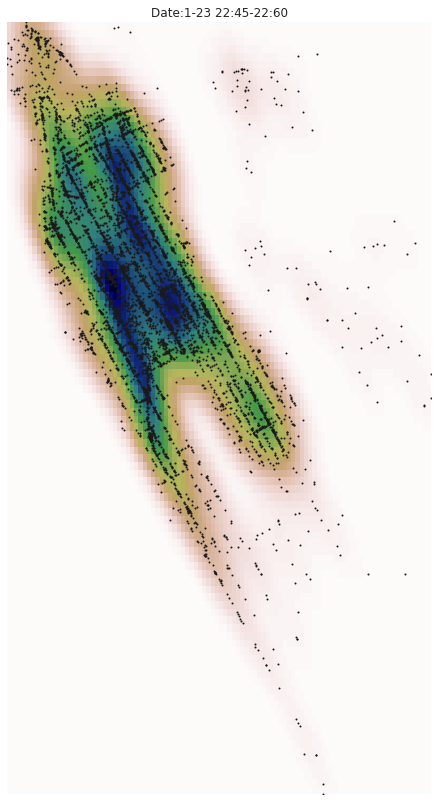

In [47]:
from scipy import stats

month, day = 1, 23

### every x minutes in this day
min = 0
interval = 15

for h in range(0, max(data_may23['pickup_hour'])):
    while min<=59 :
        tmp_data_may23 = data_may23[(data_may23['pickup_hour']==h) & (data_may23['pickup_minute']<min+interval) & (data_may23['pickup_minute']>=min)]
        x = tmp_data_may23['pickup_x']
        y = tmp_data_may23['pickup_y']
        xmin, xmax = x.min(), x.max()
        ymin, ymax = y.min(), y.max()

        X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        positions = np.vstack([X.ravel(), Y.ravel()])
        values = np.vstack([x, y])
        kernel = stats.gaussian_kde(values)
        Z = np.reshape(kernel(positions).T, X.shape)
        
        im = plt.imread('manhattan.png')
        dpi = 80
        height, width, depth = im.shape
        figsize = width / float(dpi), height / float(dpi)
        fig = plt.figure(figsize=figsize)
        ax = fig.add_axes([0, 0, 1, 1])

        # Hide spines, ticks, etc.
        ax.axis('off')

        # Display the image.
        ax.imshow(im, cmap='gray')
        implot = plt.imshow(im)

        # plot kde
        ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
                extent=[xmin, xmax, ymin, ymax])
        ax.plot(x, y, 'k.', markersize=2)
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])

        # plt.draw()
        plt.title('Date:%d-%d %d:%d-%d:%d' % (month, day, h, min, h, min+interval))
        plt.pause(0.5)
        # dots.remove()
        clear_output(wait=True)
        min += interval
    min %= 60

plt.show()